# Amazon Alexa Review
### Conduct Sentiment Analysis using Amazon Alexa Review Data - Unsupervised Machine Learning

In [157]:
import pandas as pd
import numpy as np
import sys
import nltk
import warnings
warnings.simplefilter(action='ignore')

In [158]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alicelyu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [159]:
test_data = pd.read_csv('norm_amazon_alexa.csv').dropna(subset = ['norm_review']).reset_index(drop=True)
test_data['polarity'] = test_data.feedback.map({1: 'positive', 0: 'negative'})
test_data.head(2)

,Unnamed: 0,rating,date,variation,verified_reviews,feedback,norm_review,polarity
0,0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo,positive
1,1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,love,positive


In [160]:
df_reviews = test_data.loc[:,['Unnamed: 0','norm_review','polarity']]\
                    .reset_index()\
                    .rename(columns={'index':'i','Unnamed: 0':'file_name','norm_review':'review_text'})

df_reviews.head(2)

,i,file_name,review_text,polarity
0,0,0,love echo,positive
1,1,1,love,positive


In [161]:
df_reviews.shape

(3064, 4)

In [162]:
import random
n = 3064
n_train = 0
n_test = n - n_train 

i_train = random.sample(range(n), n_train)

In [163]:
def get_train_and_test(row):
    i = row['i']
    if i in i_train:
        return 'train'
    return 'test'

In [164]:
df_reviews['type'] = df_reviews.apply(get_train_and_test,axis=1)
df_reviews.head(2)

,i,file_name,review_text,polarity,type
0,0,0,love echo,positive,test
1,1,1,love,positive,test


In [165]:
train_data = df_reviews.loc[df_reviews.type=='train',['file_name','review_text','polarity']]
test_data  = df_reviews.loc[df_reviews.type=='test' ,['file_name','review_text','polarity']]

In [167]:
test_reviews = np.array(test_data['review_text'])
test_sentiments = np.array(test_data['polarity'])

In [168]:
sample_docs = [100, 900]

for doc_index in sample_docs:
    print('Review:-')
    print(test_reviews[doc_index])
    print('Actual Labeled Sentiment:', test_sentiments[doc_index])
    print()

Review:-
awesome thing love alexa
Actual Labeled Sentiment: positive

Review:-
great sound little speaker
Actual Labeled Sentiment: positive



In [169]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold = 0.1,
                                    verbose = False):
    
    #pre-process text
#     review = normalize_accented_characters(review)
#     review = html_parser.unescape(review)
#     review = strip_html(review)
    
    #analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    #get binary sentiment
    binary_sentiment = 'positive' if scores['compound'] >= threshold\
                                   else 'negative'
    
    if verbose:
        
        #display sentiment 
        sentiment_frame = pd.DataFrame([[binary_sentiment, round(scores['compound'], 2)]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Binary Sentiment ', 'Polarity Score']], 
                                                              labels=[[0,0],[0,1]]))
        print(sentiment_frame.to_string(index=False))
    
    return binary_sentiment,scores['compound']  

In [170]:
for doc_index in sample_docs:
    print('Review:-')
    print(test_reviews[doc_index])
    print('Actual Labeled Sentiment:', test_sentiments[doc_index])    
    print()    
    final_sentiment = analyze_sentiment_vader_lexicon(test_reviews[doc_index],
                                                        threshold=0.1,
                                                        verbose=True)
    print('-'*60)                                                      

Review:-
awesome thing love alexa
Actual Labeled Sentiment: positive

 SENTIMENT STATS:               
Binary Sentiment  Polarity Score
         positive           0.85
------------------------------------------------------------
Review:-
great sound little speaker
Actual Labeled Sentiment: positive

 SENTIMENT STATS:               
Binary Sentiment  Polarity Score
         positive           0.62
------------------------------------------------------------


In [172]:
predicted_sentiment_test = pd.DataFrame([analyze_sentiment_vader_lexicon(review, threshold=-0.4394394394394394)
                     for review in test_reviews],columns = ['binary sentiment','raw score'])

In [173]:
predicted_sentiment_test.head()

,binary sentiment,raw score
0,positive,0.6369
1,positive,0.6369
2,positive,0.2023
3,positive,0.9423
4,positive,0.0000


In [177]:
all_data = pd.read_csv('norm_amazon_alexa.csv').dropna(subset = ['norm_review']).reset_index(drop=True)
all_data['polarity'] = all_data.feedback.map({1: 'positive', 0: 'negative'})

In [178]:
all_data.tail(5)

,Unnamed: 0,rating,date,variation,verified_reviews,feedback,norm_review,polarity
3059,3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,perfect kid adult everyone,positive
3060,3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,music search location check time look weather ...,positive
3061,3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,love thing run entire home tv light thermostat...,positive
3062,3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,complaint sound quality great mostly use comma...,positive
3063,3149,4,29-Jul-18,Black Dot,Good,1,good,positive


In [183]:
all_data.loc[3039,'verified_reviews']

'I dislike that it confuses my requests all the time.'

In [180]:
predicted_sentiment_test.tail(5)

,binary sentiment,raw score
3059,positive,0.5719
3060,positive,0.0000
3061,positive,0.9648
3062,positive,0.8934
3063,positive,0.4404


In [184]:
final_result = pd.concat([all_data,predicted_sentiment_test],axis=1).rename(columns={'Unnamed: 0':'person_id','binary sentiment':'predicted'})

In [185]:
final_result.shape

(3064, 10)

In [186]:
final_result.to_excel('0427_unsupervised_machine_learning_SENTIMENT.xlsx')

In [126]:
predicted_sentiment_test['binary sentiment'].value_counts()

positive    2997
negative      67
Name: binary sentiment, dtype: int64

In [187]:
from sklearn import metrics

print('ACCURACY:', np.round(metrics.accuracy_score(test_sentiments, predicted_sentiment_test['binary sentiment']), 3),"\n")

print('CONFUSION MATRIX:')
pd.crosstab(pd.Series(test_sentiments), 
            pd.Series(predicted_sentiment_test['binary sentiment']), 
            rownames = ['True'], 
            colnames = ['Predicted'], 
            margins = True)

ACCURACY: 0.925 

CONFUSION MATRIX:


Predicted,negative,positive,All
True,,,
negative,37,201,238
positive,30,2796,2826
All,67,2997,3064


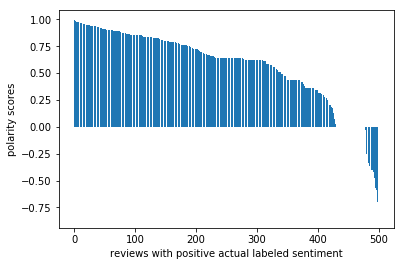

In [130]:
import matplotlib.pyplot as plt

x = range(0, 500)
pos_reviews_scored = predicted_sentiment_test[:500]['raw score']
plt.bar(x, pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("reviews with positive actual labeled sentiment")
plt.ylabel("polarity scores")
plt.show()

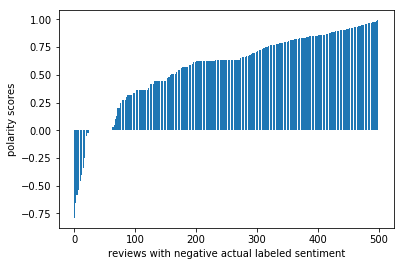

In [131]:
x = range(0, 500)
neg_reviews_scored = predicted_sentiment_test[500:1000]['raw score']
plt.bar(x, neg_reviews_scored.sort_values(ascending=True))
plt.xlabel("reviews with negative actual labeled sentiment")
plt.ylabel("polarity scores")
plt.show()

In [132]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]
    accuracy = metrics.accuracy_score(test_sentiments, binary_scores)
    return(accuracy) 

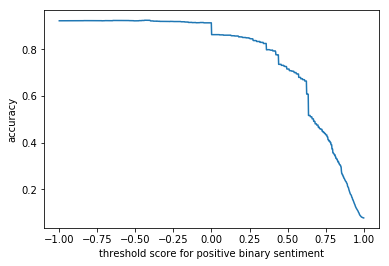

In [133]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("accuracy")
plt.show()

In [134]:
print('highest accuracy rate:', max(acc))
print('threshold value:',thresholds[acc.index(max(acc))])

highest accuracy rate: 0.9246083550913838
threshold value: -0.4394394394394394


In [135]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]    
    recall   = metrics.recall_score(test_sentiments, binary_scores, pos_label='positive')
    return(recall) 

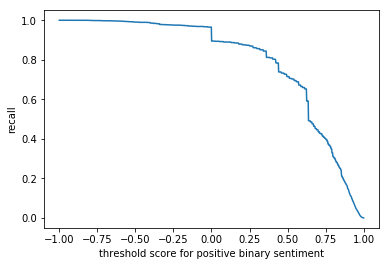

In [136]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("recall")
plt.show()

In [137]:
print('highest recall rate:', max(acc))
print('threshold value:',thresholds[acc.index(max(acc))])

highest recall rate: 1.0
threshold value: -1.0


In [138]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]
    precision = metrics.precision_score(test_sentiments, binary_scores, pos_label='positive')
    return(precision) 

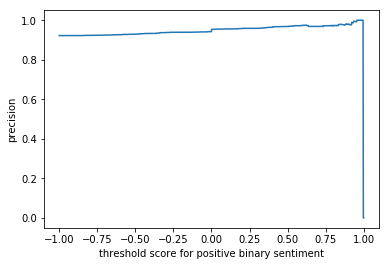

In [139]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("precision")
plt.show()

In [140]:
print('highest precision rate:', max(acc))
print('threshold value:',thresholds[acc.index(max(acc))])

highest precision rate: 1.0
threshold value: 0.9559559559559558
